# Resume Screening

**Required imports**

In [254]:
!pip install pymupdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [255]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import csv
import fitz
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from warnings import filterwarnings
filterwarnings('ignore')

 **Load the dataset**

In [256]:
dataframe = pd.read_csv('/content/UpdatedResumeDataSet.csv', encoding='utf-8')
dataframe.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


 **Data Visualization**

In [257]:
unique_categories = dataframe['Category'].unique()
category_counts = dataframe['Category'].value_counts()
print("total resumes in the dataset:", len(dataframe['Category']))
print("total unique categories:", len(unique_categories))
print("Number of records for each category of the dataset:")
print(category_counts)

total resumes in the dataset: 962
total unique categories: 25
Number of records for each category of the dataset:
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


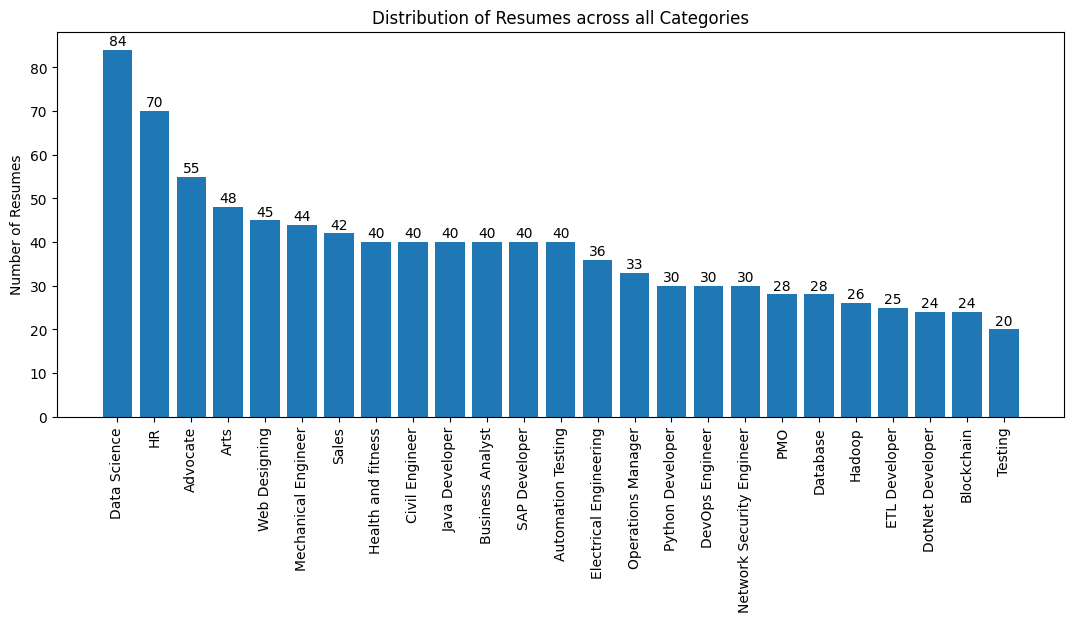

In [258]:
# Create a bar chart of the category counts
plt.figure(figsize=(13, 5))
plt.bar(range(len(unique_categories)), category_counts)

# Label the x-axis with the category names
plt.xticks(range(len(unique_categories)), unique_categories, rotation=90)

# Label the y-axis with the count of resumes in each category
plt.ylabel('Number of Resumes')

# Add the value of each category on top of its bar
for i, count in enumerate(category_counts):
    plt.text(i, count + 1, str(count), ha='center')

# Set the title of the plot
plt.title('Distribution of Resumes across all Categories')

# Show the plot
plt.show()

**Data Pre-processing**

In [259]:
def cleanResume(resumeText):

    resumeText = resumeText.lower()
    resumeText = re.sub(r'http\S+', '', resumeText)  # removes http URLs
    resumeText = re.sub(r'www\S+', '', resumeText)  # removes www URLs
    resumeText = re.sub(r'#\S+', '', resumeText)  # removes hashtags
    resumeText = re.sub(r'@\S+', '', resumeText)  # removes mentions
    resumeText = re.sub(r'[_-]', ' ', resumeText)  # add space replacing hiphen
    resumeText = re.sub(r'[^a-zA-Z]', ' ', resumeText)  # removes non-alphabetical characters
    resumeText = re.sub('\s+', ' ', resumeText)  # removes extra whitespace

    tokens = resumeText.split()
    words = [i for i in tokens if i not in stop_words]
    resumeText = (" ").join(words)

    return resumeText

In [260]:
dataframe['cleaned_resume'] = dataframe.Resume.apply(lambda x: cleanResume(x))

label_encoder = LabelEncoder()
dataframe['Category'] = label_encoder.fit_transform(dataframe['Category'])
dataframe.head(5)

,Category,Resume,cleaned_resume
0,6,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,6,Education Details \r\nMay 2013 to May 2017 B.E...,education details may may b e uit rgpv data sc...
2,6,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana sql ...
4,6,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...


In [261]:
# get the unique original labels in the corresponding encoded order
unique_original_labels = list(label_encoder.classes_)
print('unique_original_labels:', unique_original_labels)

unique_original_labels: ['Advocate', 'Arts', 'Automation Testing', 'Blockchain', 'Business Analyst', 'Civil Engineer', 'Data Science', 'Database', 'DevOps Engineer', 'DotNet Developer', 'ETL Developer', 'Electrical Engineering', 'HR', 'Hadoop', 'Health and fitness', 'Java Developer', 'Mechanical Engineer', 'Network Security Engineer', 'Operations Manager', 'PMO', 'Python Developer', 'SAP Developer', 'Sales', 'Testing', 'Web Designing']


In [262]:
input_variable = dataframe['cleaned_resume']
output_variable = dataframe['Category']

**Split available resumes dataset into train, validation, and test data**

In [263]:
# train:val:test = 75:10:15
train_X, test_X, train_Y, test_Y = train_test_split(input_variable, output_variable, random_state=42, shuffle=True, test_size=0.15)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, random_state=42, shuffle=True, test_size=0.1176)

**Tokenizing features and labels**

In [264]:
max_vocab_size = 30000

word_tokenizer = Tokenizer(num_words = max_vocab_size, oov_token = "na")
word_tokenizer.fit_on_texts(input_variable)

def feature_tokenizer(X_variable, Y_variable = np.array([[0], [1]])):

    X_var_sequences = word_tokenizer.texts_to_sequences(X_variable)
    tokenized_X = pad_sequences(X_var_sequences, maxlen = max_vocab_size, padding = 'post', truncating = 'post')
    
    Y_variable = np.array(Y_variable)
    Y_variable = Y_variable.reshape(np.shape(Y_variable)[0], 1)

    return tokenized_X, Y_variable
    
train_X, train_Y = feature_tokenizer(train_X, train_Y)
val_X, val_Y = feature_tokenizer(val_X, val_Y)
test_X, test_Y = feature_tokenizer(test_X, test_Y)
print('vectorized train_X', train_X[0:5])
print('shape of train_X', np.shape(train_X))

vectorized train_X [[  84 1063  289 ...    0    0    0]
 [ 144   34 3174 ...    0    0    0]
 [ 154   85   67 ...    0    0    0]
 [ 154   85  130 ...    0    0    0]
 [  35    7  106 ...    0    0    0]]
shape of train_X (720, 30000)


# LSTM

**Building the model**

In [265]:
embedding_dimension = 64

# LSTM model takes the input vocabulary of size 30000, and output embedding dimension of size 64 
LSTM_model = Sequential([Embedding(max_vocab_size, embedding_dimension,), Bidirectional(LSTM(64)), Dense(64, activation='relu'), Dense(25, activation='softmax')])
LSTM_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          1920000   
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 25)                1625      
                                                                 
Total params: 1,995,929
Trainable params: 1,995,929
Non-trainable params: 0
_________________________________________________________________


In [266]:
LSTM_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

Early_Stopping_parameter = EarlyStopping(monitor = 'val_loss', patience = 2)

LSTM_model_history = LSTM_model.fit(train_X, train_Y, epochs = 20, validation_data=(val_X, val_Y), callbacks=[Early_Stopping_parameter])

Epoch 1/20
23/23 [==============================] - 50s 2s/step - loss: 3.1985 - accuracy: 0.0931 - val_loss: 3.1493 - val_accuracy: 0.0928
Epoch 2/20
23/23 [==============================] - 36s 2s/step - loss: 3.1047 - accuracy: 0.0917 - val_loss: 3.2377 - val_accuracy: 0.0103
Epoch 3/20
23/23 [==============================] - 39s 2s/step - loss: 2.8728 - accuracy: 0.1389 - val_loss: 2.7768 - val_accuracy: 0.1443
Epoch 4/20
23/23 [==============================] - 37s 2s/step - loss: 2.6524 - accuracy: 0.1653 - val_loss: 2.5236 - val_accuracy: 0.2371
Epoch 5/20
23/23 [==============================] - 37s 2s/step - loss: 2.4276 - accuracy: 0.2139 - val_loss: 2.3089 - val_accuracy: 0.2887
Epoch 6/20
23/23 [==============================] - 36s 2s/step - loss: 2.2298 - accuracy: 0.3056 - val_loss: 2.0779 - val_accuracy: 0.3608
Epoch 7/20
23/23 [==============================] - 36s 2s/step - loss: 1.9345 - accuracy: 0.4000 - val_loss: 1.7771 - val_accuracy: 0.5773
Epoch 8/20
23/23 [==

**evaluating the model**

In [267]:
LSTM_model_score = LSTM_model.evaluate(test_X, test_Y, verbose = 1)
# print("LSTM model loss value:", LSTM_model_score[0])
print("LSTM model Test Accuracy:", LSTM_model_score[1])

5/5 [==============================] - 3s 576ms/step - loss: 0.6189 - accuracy: 0.8138
LSTM model Test Accuracy: 0.8137931227684021


In [268]:
LSTM_prediction_val = LSTM_model.predict(test_X)
y_actual = np.reshape(test_Y, (1, len(test_Y)))[0]
y_pred = np.argmax(LSTM_prediction_val, axis=1)
print("\n%s\n" %(metrics.classification_report(y_actual, y_pred)))

5/5 [==============================] - 4s 559ms/step

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         6
           6       1.00      1.00      1.00         3
           7       1.00      0.60      0.75         5
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         7
          11       0.62      1.00      0.77         5
          12       0.88      0.78      0.82         9
          13       0.60      1.00      0.75         3
          14       1.00      0.71      0.83         7
          15       1.00      1.00      1.00        11
          16       0.18    

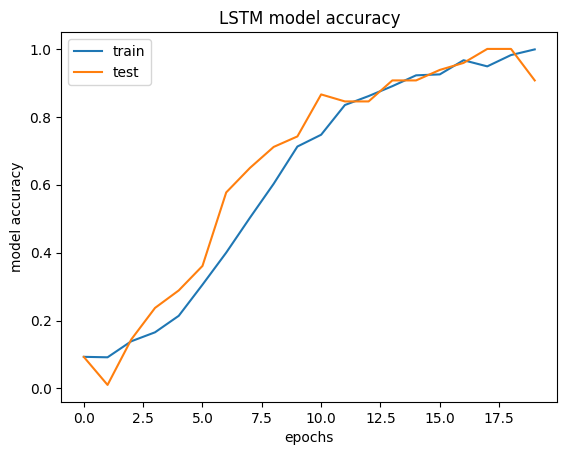

In [269]:
plt.plot(LSTM_model_history.history['accuracy'])
plt.plot(LSTM_model_history.history['val_accuracy'])

plt.title('LSTM model accuracy')
plt.ylabel('model accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# KNN

In [270]:
knn_model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 5))
knn_model.fit(train_X, train_Y)
prediction = knn_model.predict(test_X)
print("\n%s\n" % (metrics.classification_report(test_Y, prediction)))
print('Accuracy of KNeighbors Classifier on training set:', knn_model.score(train_X, train_Y))
print('Accuracy of KNeighbors Classifier on test set:', knn_model.score(test_X, test_Y))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.71      1.00      0.83         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         2
           5       1.00      0.17      0.29         6
           6       1.00      0.67      0.80         3
           7       0.00      0.00      0.00         5
           8       0.60      0.90      0.72        10
           9       0.60      0.75      0.67         4
          10       0.88      1.00      0.93         7
          11       0.83      1.00      0.91         5
          12       0.62      0.56      0.59         9
          13       1.00      1.00      1.00         3
          14       1.00      0.71      0.83         7
          15       1.00      1.00      1.00        11
          16       0.71      1.00      0.83         5
          17       1.00   

# Realtime resume screening

In [271]:
def pdf_csv(files_count):

    # Open a CSV file for writing
    with open('test_resume.csv', 'w', newline='') as f:
        writer = csv.writer(f) 
        writer.writerow(['Resume'])

        for i in range(files_count):
          doc = fitz.open('/content/Resume{}.pdf'.format(i+1))
          text = ""

          for page in doc:
            text += page.get_text()

          # Write the keys of the dictionary as the header row
          writer.writerow([text])

In [272]:
pdf_csv(2)
test_dataframe = pd.read_csv('/content/test_resume.csv', encoding='utf-8')
test_dataframe.head()

,Resume
0,Rajkumar Gara \nEmail ID: rajkumar.gara3@gmail...
1,Sharath Reddy Dopathi \n +1(260)804-1965 | ...


**Data Pre-processing**

In [273]:
test_dataframe['cleaned_resume'] = test_dataframe.Resume.apply(lambda x: cleanResume(x))
test_dataframe.head()

,Resume,cleaned_resume
0,Rajkumar Gara \nEmail ID: rajkumar.gara3@gmail...,rajkumar gara email id rajkumar gara mobile li...
1,Sharath Reddy Dopathi \n +1(260)804-1965 | ...,sharath reddy dopathi linkedin dopathisharathr...


**LSTM prediction**

In [274]:
target_category = 'Data Science'
target_category_threshold = 0.0
target_index = unique_original_labels.index(target_category)


test_input_variable = test_dataframe['cleaned_resume']
resume_ranking = []
LSTM_test_input, _ = feature_tokenizer(test_input_variable)
LSTM_prediction = LSTM_model.predict(LSTM_test_input)
print('LSTM_prediction', LSTM_prediction)

for i in range(len(LSTM_prediction)):
  if LSTM_prediction[i][target_index] >= target_category_threshold:
    resume_ranking.append(round(LSTM_prediction[i][target_index] * 100, 2))

if resume_ranking == []:
  print("could not be able to rank the resume")

else:
  print('resume_ranking:', resume_ranking)

1/1 [==============================] - 1s 539ms/step
LSTM_prediction [[4.7422353e-05 2.4054525e-06 1.1867258e-02 1.4885696e-02 3.5102235e-03
  7.6077913e-06 6.8781662e-01 8.7956803e-05 9.2064083e-02 1.6072515e-03
  1.0878704e-06 1.8910617e-06 1.5674821e-04 5.8555527e-04 5.7766167e-05
  4.3236148e-05 2.5262663e-08 6.4530171e-04 3.6654308e-09 8.8275319e-06
  1.0244785e-01 8.8897552e-03 1.2973999e-05 6.1407837e-07 7.5251780e-02]
 [4.5301997e-05 2.9118553e-07 2.6380839e-03 2.2387126e-01 2.4914427e-03
  2.9638855e-07 2.9658404e-01 1.2998073e-06 1.4374200e-04 1.4366930e-02
  5.4163056e-09 4.4243739e-06 1.0593651e-05 1.0814048e-06 1.3187098e-04
  3.1170519e-05 9.7781685e-09 1.2684274e-03 5.1393938e-09 2.7878440e-07
  6.4731357e-03 1.0584462e-02 3.5704932e-06 8.8003560e-09 4.4134828e-01]]
resume_ranking: [68.78, 29.66]


In [275]:
KNN_prediction = knn_model.predict(LSTM_test_input)
KNN_prediction_proba = knn_model.predict_proba(LSTM_test_input)
# print(LSTM_test_input[0][0:300])
# print(np.shape(LSTM_test_input))
print('KNN_prediction', KNN_prediction)
# print('KNN_prediction_proba', KNN_prediction_proba)

KNN_prediction [24 24]
